In [1]:
from src.Library import *
from Data_Preparation import *
#from Data_Preparation2 import *
import folium 
import scipy
import sklearn
from IPython.display import display
from sklearn import preprocessing
from itertools import combinations
import pickle
from sklearn import decomposition
from icecream import ic 
import os
from tqdm import tqdm
import nbimporter
from datetime import datetime
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc , roc_auc_score, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from datetime import datetime, time
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, display
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [2]:
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

# Create the data with all the features for a specific vehicle

In [3]:
Prepare_metadata_by_vehicle_number(460631)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16341.44it/s]


# Import all the data created above

In [4]:

df = concated_data_with_feat(460631)
df.columns = df.columns.str.upper()
df["START_HOUR"] = pd.to_datetime(df["START_DRIVE"]).dt.hour
df["END_HOUR"] = pd.to_datetime(df["END_DRIVE"]).dt.hour
df = df.drop(["START_DRIVE", "END_DRIVE"], axis=1)

# Convert hour columns to datetime.time objects
# df["START_HOUR"] = df["START_HOUR"].apply(lambda x: time(int(x), 0))
# df["END_HOUR"] = df["END_HOUR"].apply(lambda x: time(int(x), 0))
df.index = df['DRIVE_ID']
#df.drop(['DRIVE_ID'],axis=1,inplace=True)
df.columns = df.columns.str.lower()

# Extract the list of coordinates from the imported data

In [5]:
df["corrs"] = df.apply(lambda row: (round(row["start_latitude"], 2),
                                    round(row["start_longitude"], 2),
                                    round(row["end_latitude"], 2),
                                    round(row["end_longitude"], 2)), axis=1)
cors_lst = list(df['corrs'].unique())


# Prepare the data with all the features for each coordinate
it will be used for the scaling later

In [6]:
Prepare_coors_metadata_by_coors_lst(coor_lst=cors_lst)

# Creating pickle file for each coordinate with its [df_count, df_mean, df_std] by that order

In [7]:
for cor in cors_lst:
     create_features_for_coor(coors=cor)

In [8]:
df.index = df['drive_id']
df

,drive_id,start_latitude,start_longitude,end_latitude,end_longitude,mean_speed,std_speed,min_speed,25%_speed,50%_speed,...,acceleration2,acceleration3,speed1,speed2,speed3,sum_events,vehicle_id,start_hour,end_hour,corrs
drive_id,,,,,,,,,,,,,,,,,,,,,
12808103918,12808103918,32.165485,34.857773,32.112946,34.818150,41.898990,28.191942,1.0,14.50,39.0,...,0,0,0,0,0,0,460631.0,6,6,"(32.17, 34.86, 32.11, 34.82)"
12809856354,12809856354,32.070026,34.829456,32.167912,34.799416,63.196581,33.922340,1.0,32.00,75.0,...,0,0,0,0,0,0,460631.0,12,13,"(32.07, 34.83, 32.17, 34.8)"
12810378837,12810378837,32.167870,34.799389,32.165478,34.857697,33.166667,19.889576,1.0,14.00,35.5,...,0,0,0,0,0,0,460631.0,14,15,"(32.17, 34.8, 32.17, 34.86)"
12812256953,12812256953,32.165455,34.857704,32.160561,34.807297,21.417476,19.594679,1.0,4.00,14.0,...,0,0,0,0,0,0,460631.0,11,11,"(32.17, 34.86, 32.16, 34.81)"
12812532671,12812532671,32.155720,34.795891,32.165466,34.857758,30.876543,18.919159,1.0,15.00,32.0,...,0,0,0,0,0,0,460631.0,14,14,"(32.16, 34.8, 32.17, 34.86)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52964046721,52964046721,32.165543,34.857712,32.187866,34.877132,19.300000,12.736603,1.0,11.75,19.0,...,0,0,0,0,0,1,460631.0,8,9,"(32.17, 34.86, 32.19, 34.88)"
52965009685,52965009685,32.187855,34.877079,32.112881,34.818039,56.431193,34.133552,1.0,23.00,72.0,...,0,0,0,0,0,0,460631.0,11,11,"(32.19, 34.88, 32.11, 34.82)"
52967424318,52967424318,32.112736,34.818058,32.165535,34.857666,36.760331,23.538984,2.0,18.00,33.0,...,0,0,0,0,0,0,460631.0,17,17,"(32.11, 34.82, 32.17, 34.86)"


In [9]:
# line=df[df['drive_id']==29557623504]
# for col in line.columns:
#     print(line[col],'\n')

In [10]:
PATH_models = '/data/overflow/chenbg/AggData/tau_afeka_models'
filename2 = PATH_models+'/tau_afeka_datasets_and_important_features'
loaded_datasets = pickle.load(open(filename2, 'rb'))
columns_og = loaded_datasets[4]
columns = columns_og +['start_latitude', 'start_longitude', 'end_latitude', 'end_longitude']

In [11]:

scaled_df = scaling_by_coors_feat(df,460631)
scaled_df

,drive_id,start_latitude,start_longitude,end_latitude,end_longitude,mean_speed,std_speed,min_speed,25%_speed,50%_speed,...,acceleration2,acceleration3,speed1,speed2,speed3,sum_events,vehicle_id,start_hour,end_hour,corrs
drive_id,,,,,,,,,,,,,,,,,,,,,
12808103918,12808103918,32.165485,34.857773,32.112946,34.818150,0.821431,0.806878,-0.278291,-0.188115,0.812124,...,0,0,0,0,0,0,460631.0,6,6,"(32.17, 34.86, 32.11, 34.82)"
12809856354,12809856354,32.070026,34.829456,32.167912,34.799416,2.205333,1.770897,0.000000,1.373324,2.377689,...,0,0,0,0,0,0,460631.0,12,13,"(32.07, 34.83, 32.17, 34.8)"
12810378837,12810378837,32.167870,34.799389,32.165478,34.857697,0.329747,1.128123,-0.422116,-1.026391,0.640607,...,0,0,0,0,0,0,460631.0,14,15,"(32.17, 34.8, 32.17, 34.86)"
12812256953,12812256953,32.165455,34.857704,32.160561,34.807297,-1.235424,0.121860,-0.507275,-2.141184,-2.003283,...,0,0,0,0,0,0,460631.0,11,11,"(32.17, 34.86, 32.16, 34.81)"
12812532671,12812532671,32.155720,34.795891,32.165466,34.857758,-0.126392,0.295826,-0.447265,-0.450698,0.199608,...,0,0,0,0,0,0,460631.0,14,14,"(32.16, 34.8, 32.17, 34.86)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52964046721,52964046721,32.165543,34.857712,32.187866,34.877132,-1.630534,-1.516066,-0.277528,-0.583630,-1.220824,...,0,0,0,0,0,1,460631.0,8,9,"(32.17, 34.86, 32.19, 34.88)"
52965009685,52965009685,32.187855,34.877079,32.112881,34.818039,1.502280,1.145142,-0.301797,0.714434,2.958874,...,0,0,0,0,0,0,460631.0,11,11,"(32.19, 34.88, 32.11, 34.82)"
52967424318,52967424318,32.112736,34.818058,32.165535,34.857666,-0.349912,-0.162569,0.618543,-0.459422,-0.377336,...,0,0,0,0,0,0,460631.0,17,17,"(32.11, 34.82, 32.17, 34.86)"


In [12]:
# dummy_df1 = pd.get_dummies(scaled_df['start_hour'],prefix='start_hour')
# dummy_df2 = pd.get_dummies(scaled_df['end_hour'],prefix='end_hour')

# # # Concatenate the dummy variables with the original DataFrame
# scaled_df = pd.concat([scaled_df, dummy_df1,dummy_df2], axis=1)

In [13]:
cols_to_exclude = ['CORRS','START_HOUR','VEHICLE_ID','INDEX','END_HOUR','drive_id']
cols_to_exclude = [ x.lower() for x in cols_to_exclude]
scaled_df.drop(cols_to_exclude,axis=1,inplace=True)

In [14]:
scaled_df.describe().loc[:, df.mean() > 5]


,start_latitude,start_longitude,end_latitude,end_longitude,mean_speed,std_speed,50%_speed,75%_speed,max_speed,max_speed_diff,...,90_25%_speed,90_50%_speed,90_75%_speed,90_max_speed,90_max_speed_diff,130_mean_speed,130_25%_speed,130_50%_speed,130_75%_speed,130_max_speed
count,2606.000000,2606.000000,2606.000000,2606.000000,2606.000000,2606.000000,2606.000000,2606.000000,2606.000000,2606.000000,...,2606.000000,2606.000000,2606.000000,2606.000000,2606.000000,2606.000000,2606.000000,2606.000000,2606.000000,2606.000000
mean,32.164651,34.862642,32.164729,34.862457,8.994785,5.067776,9.194180,13.129060,18.094411,7.052934,...,9.383251,11.754435,13.697423,16.200409,5.268922,5.956567,5.565546,6.122689,6.474664,7.079715
std,0.234783,0.100281,0.234962,0.101279,20.897964,11.348517,22.440098,30.062685,39.927631,16.363741,...,23.222289,27.992818,31.963303,37.610980,13.501429,23.582875,22.274962,24.204940,25.533463,27.941090
min,29.495827,34.733185,29.495733,34.733246,-2.530358,-3.502814,-2.899759,-2.702126,-3.660370,-3.004849,...,-4.167248,-5.501184,-4.068363,-4.858914,-19.000000,-2.429562,-2.030366,-2.297927,-2.943796,-2.466785
25%,32.150335,34.823483,32.147557,34.818911,-0.605655,-0.595322,-0.553444,-0.583501,-0.657845,-0.782970,...,-0.293612,-0.309491,-0.316786,-0.318049,-0.277312,-0.084089,-0.083459,-0.084070,-0.084107,-0.084215
50%,32.165489,34.857681,32.165476,34.857647,0.120514,0.045623,0.155201,0.067818,0.010212,-0.061137,...,-0.095079,-0.096077,-0.108722,-0.115436,-0.077615,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.165546,34.857731,32.165581,34.857727,1.443932,1.545993,1.278224,1.415690,1.436390,1.155570,...,1.084454,1.129972,1.145152,1.183042,1.083440,0.000000,0.000000,0.000000,0.000000,0.000000
max,33.291439,35.759434,33.291454,35.759407,107.806358,44.277420,121.000000,133.000000,149.000000,119.000000,...,103.000000,122.000000,129.000000,148.000000,119.000000,130.628743,126.500000,134.000000,137.000000,149.000000


In [15]:
random_labled=pd.read_excel("/data/overflow/chenbg/AggData/irads_car_data/random_drives_labels.xlsx")
random_labled = random_labled.merge(scaled_df,how='inner',on='drive_id')
random_labled

,drive_id,label,start_latitude,start_longitude,end_latitude,end_longitude,mean_speed,std_speed,min_speed,25%_speed,...,break1,break2,break3,acceleration1,acceleration2,acceleration3,speed1,speed2,speed3,sum_events
0,2.680364e+10,hili,32.102577,35.209026,32.183586,34.853241,63.270916,37.967964,1.000000,28.500000,...,0,0,0,0,1,0,0,2,0,3
1,2.760891e+10,hili probably,32.165508,34.857700,32.167290,34.850910,1.503570,3.808660,-0.324240,0.113727,...,0,0,0,0,0,0,0,0,0,0
2,2.914985e+10,irad,32.165485,34.857639,32.401012,34.935108,75.554502,40.355452,1.000000,42.000000,...,0,1,0,0,0,0,0,10,3,19
3,2.932940e+10,hili probably,32.165466,34.857784,32.181477,34.836323,-0.507075,0.761185,-0.306500,-1.073950,...,2,0,0,0,0,0,0,0,0,2
4,2.955762e+10,irad,32.165436,34.857731,32.160614,34.809681,0.950650,1.873992,-0.507275,-0.101837,...,0,0,0,0,0,0,0,0,0,0
5,2.955961e+10,hili,31.999363,34.868019,32.165489,34.857761,0.758887,-0.736076,3.175426,1.108700,...,0,0,0,0,0,0,0,0,0,0
6,2.959039e+10,irad,32.165443,34.857845,32.184643,34.853191,-0.522952,-0.226384,-0.417315,-0.702306,...,0,0,0,0,0,0,0,0,0,0
7,2.962344e+10,hili,33.058880,35.434570,32.999352,35.523914,31.920530,20.361900,1.000000,14.000000,...,0,0,0,0,0,0,0,0,0,0
8,2.962836e+10,hili,32.972229,35.452881,32.705685,35.158375,77.396887,21.733787,2.000000,69.000000,...,0,0,0,0,0,0,0,0,0,0
9,2.965612e+10,irad,32.184902,34.853416,32.165470,34.857719,-0.242407,0.181793,-0.428654,-0.722712,...,0,0,0,0,0,0,0,0,0,0


In [16]:
random_labled["corrs"] = random_labled.apply(lambda row: (round(row["start_latitude"], 2),
                                                           round(row["start_longitude"], 2),
                                                           round(row["end_latitude"], 2),
                                                           round(row["end_longitude"], 2)), axis=1)
cors_lst = list(random_labled['corrs'].unique())
Prepare_coors_metadata_by_coors_lst(coor_lst=cors_lst)

In [17]:
random_labled['irad'] = np.where((random_labled['label'] == 'irad') | (random_labled['label'] == 'irad probably'), 1, 0)
random_labled.index = random_labled['drive_id']
random_labled.drop(['start_latitude','start_longitude','end_latitude','end_longitude','corrs','label','drive_id'],axis=1,inplace=True)
random_labled

,mean_speed,std_speed,min_speed,25%_speed,50%_speed,75%_speed,max_speed,mean_speed_diff,std_speed_diff,min_speed_diff,...,break2,break3,acceleration1,acceleration2,acceleration3,speed1,speed2,speed3,sum_events,irad
drive_id,,,,,,,,,,,,,,,,,,,,,
2.680364e+10,63.270916,37.967964,1.000000,28.500000,66.000000,100.000000,118.000000,0.000000,15.550669,-60.000000,...,0,0,0,1,0,0,2,0,3,0
2.760891e+10,1.503570,3.808660,-0.324240,0.113727,-0.119741,0.824308,3.304342,-0.040501,-0.556863,-2.365772,...,0,0,0,0,0,0,0,0,0,0
2.914985e+10,75.554502,40.355452,1.000000,42.000000,74.000000,115.000000,143.000000,-0.004762,17.630850,-62.000000,...,1,0,0,0,0,0,10,3,19,1
2.932940e+10,-0.507075,0.761185,-0.306500,-1.073950,-1.344844,-0.138359,0.694625,0.803242,0.435935,-1.561793,...,0,0,0,0,0,0,0,0,2,0
2.955762e+10,0.950650,1.873992,-0.507275,-0.101837,-0.106842,1.066180,2.679909,0.105884,-1.260364,-0.577580,...,0,0,0,0,0,0,0,0,0,1
2.955961e+10,0.758887,-0.736076,3.175426,1.108700,0.759329,0.363872,-0.446034,-0.170873,-0.697061,1.425612,...,0,0,0,0,0,0,0,0,0,0
2.959039e+10,-0.522952,-0.226384,-0.417315,-0.702306,-0.485101,-0.519931,0.150428,-0.045537,-1.169909,0.828221,...,0,0,0,0,0,0,0,0,0,1
2.962344e+10,31.920530,20.361900,1.000000,14.000000,33.000000,50.000000,70.000000,0.026667,10.848528,-34.000000,...,0,0,0,0,0,0,0,0,0,0
2.962836e+10,77.396887,21.733787,2.000000,69.000000,83.000000,92.000000,109.000000,-0.082031,9.485857,-69.000000,...,0,0,0,0,0,0,0,0,0,0


In [18]:
irad = [(32.12,34.8,32.17,34.86),(32.17,34.86,32.12,34.8),(32.17,34.86,32.11,34.81),(32.11,34.81,32.17,34.86)]
hili = [(32.19,34.85,32.17,34.86),(32.17,34.86,32.19,34.85),(32.17,34.86,32.11,34.82),(32.11,34.82,32.17,34.86)]

other_side_university_lat=32.11
other_side_university_long=34.81

raanana_lat = 32.19
raanana_long = 34.85

university_lat=32.12
university_long=34.8

afeka_lat = 32.11
afeka_long = 34.82

scaled_df['start_latitude'] = round(scaled_df['start_latitude'],2)
scaled_df['end_latitude'] = round(scaled_df['end_latitude'],2)
scaled_df['end_longitude'] = round(scaled_df['end_longitude'],2)
scaled_df['start_longitude'] = round(scaled_df['start_longitude'],2)

scaled_df['irad'] = np.where(
    ((scaled_df['start_latitude'] == university_lat) & (scaled_df['start_longitude'] == university_long)) |
    ((scaled_df['end_latitude'] == university_lat) & (scaled_df['end_longitude'] == university_long)) |
    ((scaled_df['start_latitude'] == other_side_university_lat) & (scaled_df['start_longitude'] == other_side_university_long)) |
    ((scaled_df['end_latitude'] == other_side_university_lat) & (scaled_df['end_longitude'] == other_side_university_long)),
    1, 
    0
)
scaled_df['hili'] = np.where(
    ((scaled_df['start_latitude'] == raanana_lat) & (scaled_df['start_longitude'] == raanana_long)) |
    ((scaled_df['end_latitude'] == raanana_lat) & (scaled_df['end_longitude'] == raanana_long)) |
    ((scaled_df['start_latitude'] == afeka_lat) & (scaled_df['start_longitude'] == afeka_long)) |
    ((scaled_df['end_latitude'] == afeka_lat) & (scaled_df['end_longitude'] == afeka_long)),
    1, 
    0
)
x = scaled_df[(scaled_df['irad'] == 1) | (scaled_df['hili'] == 1)]
x = pd.concat([x,random_labled])
x.drop(['start_latitude','start_longitude','end_latitude','end_longitude'],axis=1,inplace=True)
scaled_df
mask = x.apply(lambda x: (x > 4.5) | (x < -4.5)).any(axis=1)
# mask2 = random_labled.apply(lambda x: (x > 4.5) | (x < -4.5)).any(axis=1)
# cor_rand = random_labled[mask2]
# cor_x = x[mask]

# random_labled = random_labled[~mask2]
x = x[~mask]
y = pd.Series(x['irad'])

# x.columns = x.columns.str.lower()
x


,mean_speed,std_speed,min_speed,25%_speed,50%_speed,75%_speed,max_speed,mean_speed_diff,std_speed_diff,min_speed_diff,...,break3,acceleration1,acceleration2,acceleration3,speed1,speed2,speed3,sum_events,irad,hili
drive_id,,,,,,,,,,,,,,,,,,,,,
1.280810e+10,0.821431,0.806878,-0.278291,-0.188115,0.812124,0.794679,0.268420,0.242583,0.264083,-0.326981,...,0,0,0,0,0,0,0,0,0,1.0
1.281328e+10,1.439159,1.353770,-0.047306,1.264156,1.467683,0.995173,1.646941,-1.477096,0.694719,0.531936,...,0,0,0,0,0,0,0,1,1,0.0
1.281757e+10,0.364265,0.566589,-0.395373,-0.452315,0.752165,0.994329,-0.381820,-0.280360,-0.858883,0.763607,...,0,0,0,0,0,0,0,0,1,0.0
1.283068e+10,1.406601,2.336693,-0.255464,-0.818979,0.512935,1.831860,1.374247,0.121988,-0.516932,1.081536,...,0,0,0,0,0,0,0,1,1,0.0
1.283277e+10,-0.662613,-0.104077,-0.488071,-1.074798,-0.593192,-0.729744,0.281612,-0.584706,0.022607,0.063007,...,0,0,0,0,0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.204040e+10,-1.596957,-1.027972,-0.242536,-1.340869,-1.545735,-1.123174,-0.946611,-1.057371,-1.208936,1.447800,...,0,0,0,0,0,0,0,0,0,NaN
5.217963e+10,-1.747721,-1.223109,-0.421204,-1.012795,-1.890862,-2.174005,-0.941255,-0.091390,-1.447743,-0.050526,...,0,0,0,0,0,0,0,0,1,NaN
5.221719e+10,-0.613410,-0.087621,-0.503236,-0.633981,-0.683989,0.044280,-0.194023,0.490371,0.465679,0.501643,...,0,0,0,0,0,0,0,0,1,NaN


In [19]:
x.drop(['irad','hili'],axis=1,inplace=True)
# random_labled.drop(['hili'],axis=1,inplace=True)
# random_labled 

11111 - 94auc
gb = GradientBoostingClassifier(random_state=0, learning_rate= 0.8459282722366741 
                                , max_depth= 3, max_features= None, min_samples_leaf= 3, min_samples_split= 4, 
                                min_weight_fraction_leaf= 0.034282660672611265, n_estimators= 100, subsample= 0.89621572116)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [21]:
# x_random = random_labled.drop(['irad'],axis=1)
# y_random = pd.Series(random_labled['irad'])
# X_test = pd.concat([X_test,x_random])
# # .drop(['drive_id'],axis=1)
# y_test = pd.concat([y_test,y_random])
# y_test.reset_index(drop=True,inplace=True)

In [22]:
y_test.reset_index(drop=True,inplace=True)

Gradient Boosting Classifier:  Accuracy = 0.9375, Precision = 0.9148936170212766, Recall = 0.8958333333333334


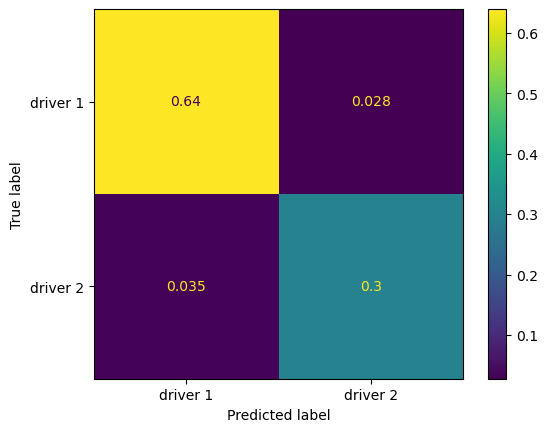

In [23]:
pred_acc = []
pred_proba_acc = []
sample_weight = list(np.ones(len(X_train)))
gb = GradientBoostingClassifier(random_state=0, learning_rate= 0.8459282722366741 , max_depth= 4,
                                max_features= None, min_samples_leaf= 3, min_samples_split= 4,
                                min_weight_fraction_leaf= 0.034282660672611265, n_estimators= 100,
                                subsample= 0.89621572116)
        
for sample in range(len(X_test)):
    X_combined_with_sample = pd.concat([X_train,X_test.iloc[:sample,:]])
    y_combined_with_sample = np.concatenate([y_train,y_test[:sample]])
 
    gb.fit(X_combined_with_sample,y_combined_with_sample,sample_weight)
    sample_weight.append(10+sample/100)
    samp = np.array(X_test.iloc[sample,:]).reshape(1, -1)
    pred_acc.append(gb.predict(samp)[0])
    pred_proba_acc.append(gb.predict_proba(samp)[0][1])
    

acc = sklearn.metrics.accuracy_score(y_test,pred_acc)
prec = sklearn.metrics.precision_score(y_test,pred_acc)
rec = sklearn.metrics.recall_score(y_test,pred_acc)
print('Gradient Boosting Classifier:  Accuracy = {}, Precision = {}, Recall = {}'.format(acc, prec,rec))
cm=sklearn.metrics.confusion_matrix(y_test,pred_acc,normalize='all')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['driver 1','driver 2'])
disp.plot() 

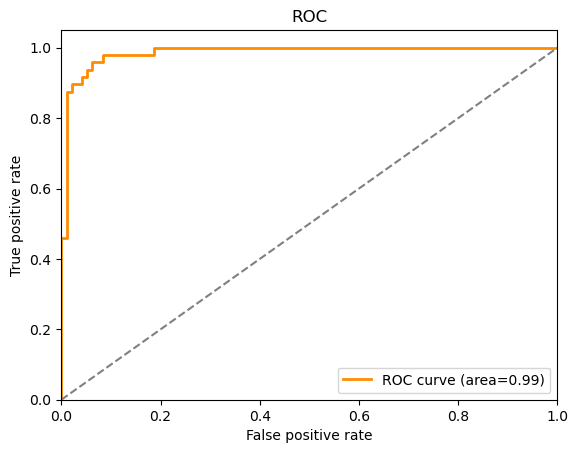

In [24]:
# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr[0],tpr[0],_ = roc_curve(y_test, pred_proba_acc)
#we have an underscore there because this functions returns 3 values 
#but we dont need the third value therefore place a an underscore there

roc_auc[0] = auc(fpr[0],tpr[0])
#plot the figure
plt.figure()
lw=2
plt.plot(fpr[0],tpr[0], color='darkorange',lw=lw,label='ROC curve (area=%0.2f)' %roc_auc[0])
plt.plot([0,1],[0,1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

In [25]:
# df_1 = pd.DataFrame({'prob':pred_proba_acc,'y':y_test,'y_':pred_acc})
# ind = len(y_test)-len(y_random)
# df_1.style.apply(lambda x: ["background: red" if round(v,0) != round(x.iloc[0],0) else "" for v in x], axis = 1)
# random_tests = df_1.iloc[ind:]
# random_tests['bull'] = abs(random_tests['y']-random_tests['y_'])
# print('the proportion of random drives sucssusfully predicted is:',1-random_tests['bull'].sum()/len(random_tests))
# random_tests                 
#ברקסים, שינוי נתיבים, האצות,האטות,שמירה על מרכז,מהירות

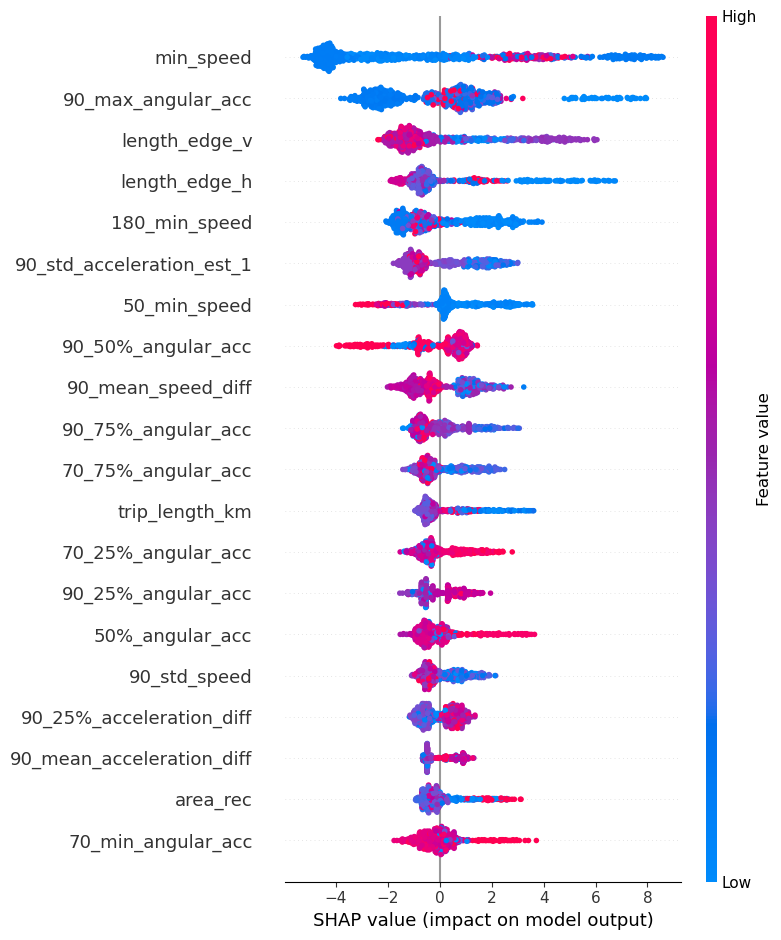

Top 15 important features:
Index(['min_speed', '90_max_angular_acc', 'length_edge_v', 'length_edge_h',
       '180_min_speed', '90_std_acceleration_est_1', '50_min_speed',
       '90_50%_angular_acc', '90_mean_speed_diff', '90_75%_angular_acc',
       '70_75%_angular_acc', 'trip_length_km', '70_25%_angular_acc',
       '90_25%_angular_acc', '50%_angular_acc'],
      dtype='object')


In [26]:
# Import necessary libraries
import shap
import numpy as np

n_top_features = 15

# Assuming you have a trained gradient boosting model stored in 'gb_model'

# Define the explainer
explainer = shap.Explainer(gb)

# Calculate SHAP values for the entire dataset
shap_values = explainer.shap_values(x)  # X is your dataset

# Plot the summary plot to visualize feature importance
shap.summary_plot(shap_values, x)  # X is your dataset

# Extract important features based on SHAP values
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
top_features_indices = np.argsort(mean_abs_shap_values)[::-1][:n_top_features]  # n_top_features is the number of top features you want to extract
top_features = x.columns[top_features_indices]

print("Top", n_top_features, "important features:")
print(top_features)


In [27]:
cols = ['min_speed', 'length_edge_v', '90_max_angular_acc', 'length_edge_h',
       '90_50%_angular_acc', '180_min_speed', '50_min_speed',
       '50%_angular_acc', '90_std_acceleration_est_1', 'trip_length_km',
       'mean_speed_diff', '90_75%_angular_acc', '70_min_angular_acc',
       '90_mean_speed_diff', '90_50%_acceleration_est_1']

In [28]:
x = scaled_df[(scaled_df['irad'] == 1) | (scaled_df['hili'] == 1)]
x = pd.concat([x,random_labled])
x.drop(['start_latitude','start_longitude','end_latitude','end_longitude'],axis=1,inplace=True)
scaled_df
mask = x.apply(lambda x: (x > 4.5) | (x < -4.5)).any(axis=1)
mask2 = random_labled.apply(lambda x: (x > 4.5) | (x < -4.5)).any(axis=1)
# cor_rand = random_labled[mask2]
# cor_x = x[mask]

random_labled = random_labled[~mask2]
x = x[~mask]

y = pd.Series(x['irad'])


In [29]:
x

,mean_speed,std_speed,min_speed,25%_speed,50%_speed,75%_speed,max_speed,mean_speed_diff,std_speed_diff,min_speed_diff,...,break3,acceleration1,acceleration2,acceleration3,speed1,speed2,speed3,sum_events,irad,hili
drive_id,,,,,,,,,,,,,,,,,,,,,
1.280810e+10,0.821431,0.806878,-0.278291,-0.188115,0.812124,0.794679,0.268420,0.242583,0.264083,-0.326981,...,0,0,0,0,0,0,0,0,0,1.0
1.281328e+10,1.439159,1.353770,-0.047306,1.264156,1.467683,0.995173,1.646941,-1.477096,0.694719,0.531936,...,0,0,0,0,0,0,0,1,1,0.0
1.281757e+10,0.364265,0.566589,-0.395373,-0.452315,0.752165,0.994329,-0.381820,-0.280360,-0.858883,0.763607,...,0,0,0,0,0,0,0,0,1,0.0
1.283068e+10,1.406601,2.336693,-0.255464,-0.818979,0.512935,1.831860,1.374247,0.121988,-0.516932,1.081536,...,0,0,0,0,0,0,0,1,1,0.0
1.283277e+10,-0.662613,-0.104077,-0.488071,-1.074798,-0.593192,-0.729744,0.281612,-0.584706,0.022607,0.063007,...,0,0,0,0,0,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.204040e+10,-1.596957,-1.027972,-0.242536,-1.340869,-1.545735,-1.123174,-0.946611,-1.057371,-1.208936,1.447800,...,0,0,0,0,0,0,0,0,0,NaN
5.217963e+10,-1.747721,-1.223109,-0.421204,-1.012795,-1.890862,-2.174005,-0.941255,-0.091390,-1.447743,-0.050526,...,0,0,0,0,0,0,0,0,1,NaN
5.221719e+10,-0.613410,-0.087621,-0.503236,-0.633981,-0.683989,0.044280,-0.194023,0.490371,0.465679,0.501643,...,0,0,0,0,0,0,0,0,1,NaN


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x[cols[:12]], y, test_size=0.33,random_state=111)

In [31]:
x_random = random_labled[cols[:12]]
y_random = pd.Series(random_labled['irad'])
X_test = pd.concat([X_test,x_random])
# .drop(['drive_id'],axis=1)
y_test = pd.concat([y_test,y_random])
y_test.reset_index(drop=True,inplace=True)

Gradient Boosting Classifier:  Accuracy = 0.9254901960784314, Precision = 0.8854166666666666, Recall = 0.9139784946236559


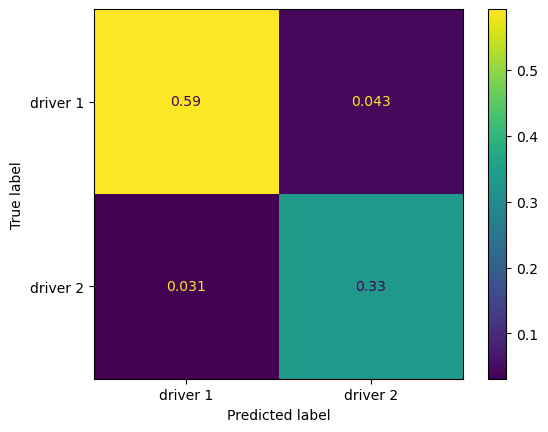

In [32]:
pred_acc = []
pred_proba_acc = []
sample_weight = list(np.ones(len(X_train)))
gb = GradientBoostingClassifier(random_state=0, learning_rate= 0.8459282722366741 , max_depth= 4,
                                max_features= None, min_samples_leaf= 3, min_samples_split= 4,
                                min_weight_fraction_leaf= 0.034282660672611265, n_estimators= 100,
                                subsample= 0.89621572116)
        
for sample in range(len(X_test)):
    X_combined_with_sample = pd.concat([X_train,X_test.iloc[:sample,:]])
    y_combined_with_sample = np.concatenate([y_train,y_test[:sample]])
 
    gb.fit(X_combined_with_sample,y_combined_with_sample,sample_weight)
    sample_weight.append(10+sample/100)
    samp = np.array(X_test.iloc[sample,:]).reshape(1, -1)
    pred_acc.append(gb.predict(samp)[0])
    pred_proba_acc.append(gb.predict_proba(samp)[0][1])
    

acc = sklearn.metrics.accuracy_score(y_test,pred_acc)
prec = sklearn.metrics.precision_score(y_test,pred_acc)
rec = sklearn.metrics.recall_score(y_test,pred_acc)
print('Gradient Boosting Classifier:  Accuracy = {}, Precision = {}, Recall = {}'.format(acc, prec,rec))
cm=sklearn.metrics.confusion_matrix(y_test,pred_acc,normalize='all')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['driver 1','driver 2'])
disp.plot() 

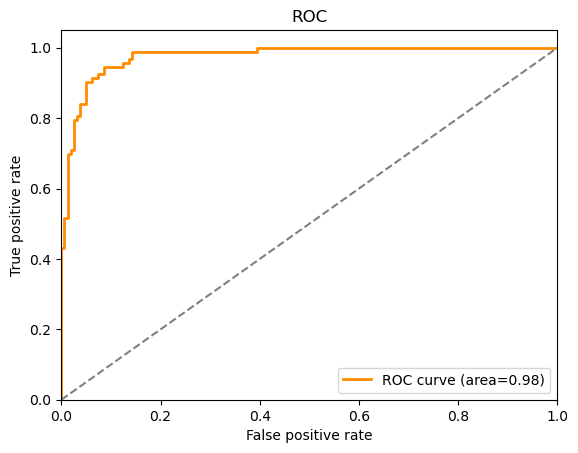

In [33]:
# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr[0],tpr[0],_ = roc_curve(y_test, pred_proba_acc)
#we have an underscore there because this functions returns 3 values 
#but we dont need the third value therefore place a an underscore there

roc_auc[0] = auc(fpr[0],tpr[0])
#plot the figure
plt.figure()
lw=2
plt.plot(fpr[0],tpr[0], color='darkorange',lw=lw,label='ROC curve (area=%0.2f)' %roc_auc[0])
plt.plot([0,1],[0,1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

In [34]:
# Assuming pred_proba_acc, y_test, and pred_acc are defined elsewhere in your code
# Create DataFrame df_1
df_1 = pd.DataFrame({'prob': pred_proba_acc, 'y': y_test, 'y_': pred_acc})

# Round the 'prob' column to 2 decimal places
df_1['prob'] = round(df_1['prob'], 2)

# Assuming y_random is defined elsewhere in your code
# Calculate the index to separate the random tests
ind = len(y_test) - len(y_random)

# Extract the random tests into random_tests DataFrame
random_tests = df_1.iloc[ind:]

# Calculate the absolute difference between the actual and predicted values
random_tests['bull'] = abs(random_tests['y'] - random_tests['y_'])

# Calculate the proportion of successfully predicted random drives
proportion_success = 1 - random_tests['bull'].sum() / len(random_tests)
print('the proportion of random drives successfully predicted is:', proportion_success)

# Apply background color to rows where 'bull' value is 1
random_tests.style.apply(lambda x: ["background: red" if 0 != round(x.iloc[3], 2) else "" for v in x], axis=1)

the proportion of random drives successfully predicted is: 1.0


,prob,y,y_,bull
237,0.000000,0,0,0
238,0.000000,0,0,0
239,1.000000,1,1,0
240,1.000000,1,1,0
241,1.000000,1,1,0
242,1.000000,1,1,0
243,1.000000,1,1,0
244,0.000000,0,0,0
245,1.000000,1,1,0
246,0.000000,0,0,0


In [87]:
import pickle

with open("/bigdata/users-home/dor/transpotation research/agg_data/preprocessGlobalFeatures/2_2019_[460631]_trips.pickle", 'rb') as handle:
    trips_lst = pickle.load(handle)
לפצל נסיעות לאורכים שווים 
אפשר חפיפה בין סדרות
לפצל בנקודות עצירה
טרנספר לרנינג (תשלים נסיעות בתור התחלה ואז תחזה זהות)
פאסט דיטידבליו אלגוריתם למדידת מרחק בין הקווים שנוצרים מהנסיעה

In [93]:
print(len(trips_lst))
for i in trips_lst[0]:
    print(i.time_series_record)

1
    vehicle_id  longitude   latitude           orig_time  speed  direction  \
11      460631  34.857728  32.165491 2019-02-01 06:40:17      0          0   
13      460631  34.857728  32.165491 2019-02-01 06:40:18      0          0   
14      460631  34.857728  32.165500 2019-02-01 06:40:21      0          0   
15      460631  34.857723  32.165503 2019-02-01 06:40:25      0          0   
16      460631  34.857713  32.165500 2019-02-01 06:40:29      0          0   
..         ...        ...        ...                 ...    ...        ...   
79      460631  34.843315  32.160441 2019-02-01 06:49:55      0          0   
80      460631  34.843321  32.160440 2019-02-01 06:50:05      0          0   
81      460631  34.843335  32.160446 2019-02-01 06:50:15      0          0   
82      460631  34.843345  32.160458 2019-02-01 06:50:22      0          0   
83      460631  34.843348  32.160468 2019-02-01 06:50:27      0          0   

    vehicle_state       mileage  road_speed  
11             

       vehicle_id  longitude   latitude           orig_time  speed  direction  \
19895      460631  34.836430  32.248701 2019-02-20 17:22:46      0          0   
19896      460631  34.836425  32.248701 2019-02-20 17:22:50      0          0   
19897      460631  34.836421  32.248703 2019-02-20 17:22:56      0          0   
19898      460631  34.836420  32.248701 2019-02-20 17:23:00      0          0   
19899      460631  34.836416  32.248700 2019-02-20 17:23:04      0          0   
...           ...        ...        ...                 ...    ...        ...   
20090      460631  34.877638  32.307701 2019-02-20 17:53:58      0          0   
20091      460631  34.877625  32.307705 2019-02-20 17:54:08      0          0   
20092      460631  34.877611  32.307705 2019-02-20 17:54:16      0          0   
20093      460631  34.877611  32.307706 2019-02-20 17:54:17      0          0   
20094      460631  34.877615  32.307705 2019-02-20 17:54:21      0          0   

       vehicle_state       

In [151]:
import torch
from torch import nn
from sklearn.metrics import roc_auc_score

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input_dim, 300)
        self.layer2 = nn.Linear(300, 200)
        self.layer3 = nn.Linear(200, 108)
        self.layer4 = nn.Linear(108, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.tanh(self.layer3(x))
        x = self.sigmoid(self.layer4(x))
        return x

def train_and_evaluate_model(x_train, y_train, x_test, y_test):
    # Hyperparameters with typical ranges
    learning_rate = 0.0001  # Typical range: [1e-5, 1e-1]
    epochs = 2000  # Typical range: [10, 1000]
    batch_size = 75  # Typical range: [16, 128]
    hidden_dim = 200  # Typical range: [10, 1000]

    # Create a model
    model = Net(x_train.shape[1], hidden_dim, 1)

    # Define loss function and optimizer
    criterion = nn.BCELoss()   #nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Convert numpy arrays to PyTorch tensors
    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float().view(-1, 1)
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).float().view(-1, 1)

    # Train the model
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluate the model on the training data
    model.eval()
    outputs = model(x_train)
    roc_auc_train = roc_auc_score(y_train.detach().numpy(), outputs.detach().numpy())
    print(f"Train ROC AUC: {roc_auc_train}")

    # Evaluate the model on the test data
    outputs = model(x_test)
    roc_auc_test = roc_auc_score(y_test.detach().numpy(), outputs.detach().numpy())
    print(f"Test ROC AUC: {roc_auc_test}")
    
    # Corrected code starts here
    df_1 = pd.DataFrame({'prob': np.array(outputs.detach().numpy()).flatten(), 'y': np.array(y_test).flatten(), 'y_': np.array(pred_acc).flatten()})
    ind = len(y_test) - len(y_random)
    df_1.style.apply(lambda x: ["background: red" if round(v, 0) != round(x.iloc[0], 0) else "" for v in x], axis=1)
    random_tests = df_1.iloc[ind:]
    random_tests['bull'] = abs(random_tests['y'] - random_tests['y_'])
    print('the proportion of random drives successfully predicted is:', 1 - random_tests['bull'].sum() / len(random_tests))
    random_tests

    return random_tests




train_and_evaluate_model(x_train=np.array(X_train), y_train=np.array(y_train), x_test=np.array(X_test), y_test=np.array(y_test))

Train ROC AUC: 1.0
Test ROC AUC: 0.7602108036890646
the proportion of random drives successfully predicted is: 0.4444444444444444


,prob,y,y_,bull
140,0.999801,0.0,0,0.0
141,0.000929,0.0,1,1.0
142,0.000131,1.0,0,1.0
143,0.733892,1.0,0,1.0
144,0.431595,1.0,0,1.0
145,0.018956,1.0,0,1.0
146,0.986152,1.0,1,0.0
147,0.000088,0.0,0,0.0
148,0.974771,1.0,0,1.0
149,0.878088,0.0,0,0.0


# finding the drives which will be labled as drivers
1. Group the trips according to starting location, final location, and departure time from home.
2. Find the most frequent trip.
3. Label her as one driver, train the model on this set of trips and test on the second largest set using active learning.
4. If the model recognized that most of the trips were made by the same driver, label the second group as the first driver, otherwise label the second group as driver 2.

In [ ]:
def count_drives_from_month(year='2018', month='05',directory = '/data/inputs/Year_Data/DRIVES'):

    # Create the path for the year and month
    year_path = os.path.join(directory, year)
    month_path = os.path.join(year_path, month)

    # Check if the year and month directories exist
    if not os.path.exists(year_path) or not os.path.exists(month_path):
        print("Year or month not found.")
        
        return

    # List all the day folders
    days = os.listdir(month_path)

    # List to store the DataFrames
    dfs = []

    # Iterate over days
    for day in days:
        day_path = os.path.join(month_path, day)

        # List all the CSV files in the day folder
        csv_files = [f for f in os.listdir(day_path) if f.endswith('.csv.gz')]

        # Iterate over CSV files
        for csv_file in csv_files:
            csv_file_path = os.path.join(day_path, csv_file)

                    # Read CSV file into a DataFrame
        df = pd.read_csv(csv_file_path)
        df.columns = map(str.upper, df.columns)
        df = df[df["START_DRIVE"] != df["END_DRIVE"] ]
        # Select specific columns and round latitude/longitude columns
        df = df[["DRIVE_ID", "VEHICLE_ID", "START_DRIVE", "START_LATITUDE", "START_LONGITUDE", 
                 "END_DRIVE", "END_LATITUDE", "END_LONGITUDE"]].dropna()
        df["START_LATITUDE"] = df["START_LATITUDE"].round(3)
        df["START_LONGITUDE"] = df["START_LONGITUDE"].round(3)
        df["END_LATITUDE"] = df["END_LATITUDE"].round(3)
        df["END_LONGITUDE"] = df["END_LONGITUDE"].round(3)
        df = df[(df["END_LONGITUDE"] != df["START_LONGITUDE"]) & (df["END_LATITUDE"] != df["START_LATITUDE"])]
        # Separate the date and hour columns
        df["DATE"] = pd.to_datetime(df["START_DRIVE"]).dt.date
        df["START_HOUR"] = pd.to_datetime(df["START_DRIVE"]).dt.hour
        df["END_HOUR"] = pd.to_datetime(df["END_DRIVE"]).dt.hour
        df = df.drop(["START_DRIVE", "END_DRIVE"], axis=1)

        # Convert hour columns to datetime.time objects
#         df["START_HOUR"] = df["START_HOUR"].apply(lambda x: time(int(x), 0))
#         df["END_HOUR"] = df["END_HOUR"].apply(lambda x: time(int(x), 0))

        # Combine date and time to create Timestamp
#         df["START_HOUR"] = df.apply(lambda row: pd.Timestamp.combine(row["DATE"], row["START_HOUR"]), axis=1)
#         df["END_HOUR"] = df.apply(lambda row: pd.Timestamp.combine(row["DATE"], row["END_HOUR"]), axis=1)
        # Add a column with the name of the day
        df["DAY_OF_WEEK"] = df["DATE"].apply(lambda x: x.strftime("%A"))

        # Append the DataFrame to a list if needed
        dfs.append(df)

    # Check if any DataFrames were found
    if not dfs:
        print("No CSV files found.")
        return

    # Concatenate the DataFrames
    concatenated_df = pd.concat(dfs, ignore_index=True)
#     concatenated_df = dfs[0].unionAll(dfs[1:]) if len(dfs) > 1 else dfs[0]

    # Group by 'VEHICLE_ID', 'START_LATITUDE', 'START_LONGITUDE', 'END_LATITUDE', 'END_LONGITUDE', 'START_HOUR', and 'END_HOUR' and count the occurrences
    grouped_df = concatenated_df.groupby(['VEHICLE_ID', 'START_LATITUDE', 'START_LONGITUDE', 'END_LATITUDE', 'END_LONGITUDE', 'START_HOUR']).size().reset_index(name='num_drives')

    
    return grouped_df

In [ ]:
# change all column names to uppercase
df.columns = df.columns.str.upper()
if os.path.exists("/bigdata/users-home/dor/transpotation research/agg_data/tagged_drives18_19.csv"):
    agg_drives = pd.read_csv("/bigdata/users-home/dor/transpotation research/agg_data/tagged_drives18_19.csv")
    agg_drives['START_HOUR'] = pd.to_datetime(agg_drives['START_HOUR']).dt.hour
    agg_drives['END_HOUR'] = pd.to_datetime(agg_drives['END_HOUR']).dt.hour
    
else:
    agg_drives = pd.DataFrame()  # Initialize an empty DataFrame
    y2020_drives = pd.DataFrame()
    for year in ['2018','2019','2020']:
        for i in range(1, 13, 1):
            if year != '2020':
                if i == 1 and year == '2018':
                    agg_drives = count_drives_from_month(month="0" + str(i), year=year)
                    cols_group = list(agg_drives.columns.copy())  # Create a copy of the columns list
                    cols_group.remove('num_drives')  # Remove 'num_drives' from the copied list
                elif len(str(i)) == 1:
                    agg_drives = pd.concat([count_drives_from_month(month="0" + str(i), year=year), agg_drives], ignore_index=True)

                else:
                    agg_drives = pd.concat([count_drives_from_month(month=str(i), year=year), agg_drives], ignore_index=True)
                agg_drives = agg_drives.groupby(by=cols_group).agg({'num_drives': 'sum'}).reset_index()
            else:
                if i == 1 and year == '2020':
                    y2020_drives = count_drives_from_month(month="0" + str(i), year=year)
                    cols_group = list(y2020_drives.columns.copy())  # Create a copy of the columns list
                    cols_group.remove('num_drives')  # Remove 'num_drives' from the copied list
                elif len(str(i)) == 1:
                    y2020_drives = pd.concat([count_drives_from_month(month="0" + str(i), year=year), y2020_drives], ignore_index=True)

                else:
                    y2020_drives = pd.concat([count_drives_from_month(month=str(i), year=year), y2020_drives], ignore_index=True)
                y2020_drives = y2020_drives.groupby(by=cols_group).agg({'num_drives': 'sum'}).reset_index()
    y2020_drives = y2020_drives['VEHICLE_ID'].unique()
    
agg_drives

In [ ]:
agg_drives = agg_drives[agg_drives['num_drives'] > 7].sort_values(by=['VEHICLE_ID', 'num_drives'], ascending=[False, False])

# Adding the count_diffrent_drives column
# agg_drives['count_diffrent_drives'] = agg_drives.groupby('VEHICLE_ID')['VEHICLE_ID'].transform('count')
agg_drives=agg_drives[agg_drives['VEHICLE_ID']==460631]
# agg_drives.to_csv("/bigdata/users-home/dor/transpotation research/agg_data/tagged_drives18_19.csv")
# convert the column START_HOUR to datetime64[ns]
# agg_drives['START_HOUR'] = agg_drives['START_HOUR'].astype('timedelta64[ns]')
# df['START_HOUR'] = df['START_HOUR'].astype('timedelta64[ns]')
agg_drives

In [ ]:
def tag_drives(agg_drives,driver=1):
    drives_df = agg_drives.copy()
    drives_df['driver'] = 0
    driver_dict = {}
#     agg_drives.at[3263176, 'driver'] = 0
    for i, row in drives_df.iterrows():
#         agg_drives.at[i, 'driver'] = int(0)
        if  i == drives_df.index[0]:
            drives_df.at[i, 'driver'] = driver
            driver_dict[i] = row
        else:
            for j in driver_dict:
                if (
                    (row['START_LATITUDE'] == driver_dict[j]['END_LATITUDE']
                    and row['START_LONGITUDE'] == driver_dict[j]['END_LONGITUDE']
                    and row['END_LATITUDE'] == driver_dict[j]['START_LATITUDE']
                    and row['END_LONGITUDE'] == driver_dict[j]['START_LONGITUDE'])
                    or (row['START_LATITUDE'] == driver_dict[j]['START_LATITUDE']
                    and row['START_LONGITUDE'] == driver_dict[j]['START_LONGITUDE']
                    and row['END_LATITUDE'] == driver_dict[j]['END_LATITUDE']
                    and row['END_LONGITUDE'] == driver_dict[j]['END_LONGITUDE'])):

                    if (row['START_HOUR'] in [driver_dict[j]['START_HOUR'] + 1, driver_dict[j]['START_HOUR'] - 1, driver_dict[j]['START_HOUR']]):
                            drives_df.at[i, 'driver'] = driver
#                         break  # Exit the loop once a match is found
    return drives_df[drives_df['driver']==1] , drives_df[drives_df['driver']==0]



In [ ]:
def get_drives(df , drives_group):   
    driver1_lst = []
    random_0 = []
    k=0
    for i, row in df.iterrows():
        for j, row2 in drives_group.iterrows():
            if (round(row['START_LATITUDE'],2) == row2['START_LATITUDE']
                and round(row['START_LONGITUDE'],2) == row2['START_LONGITUDE']
                and round(row['END_LATITUDE'],2) == row2['END_LATITUDE']
                and round(row['END_LONGITUDE'],2) == row2['END_LONGITUDE']
                and row['START_HOUR'] == row2['START_HOUR']):
                driver1_lst.append(i)
                break

            elif k<10 and j ==drives_group.index[-1] :
                random_0.append(i)
                k=k+1
    return driver1_lst, random_0

In [ ]:
def get_auc(x,y,test_size=0.4):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    pred_acc = []
    pred_proba_acc = []
    sample_weight = list(np.ones(len(X_train)))
    gb = GradientBoostingClassifier(random_state=0, learning_rate= 0.8459282722366741 , max_depth= 4,
                                    max_features= None, min_samples_leaf= 3, min_samples_split= 4,
                                    min_weight_fraction_leaf= 0.034282660672611265, n_estimators= 100,
                                    subsample= 0.89621572116)

    for sample in range(len(X_test)):
        X_combined_with_sample = pd.concat([X_train,X_test.iloc[:sample,:]])
        y_combined_with_sample = np.concatenate([y_train,y_test[:sample]])

        gb.fit(X_combined_with_sample,y_combined_with_sample,sample_weight)
        sample_weight.append(10+sample)
        samp = np.array(X_test.iloc[sample,:]).reshape(1, -1)
        pred_acc.append(gb.predict(samp)[0])
        pred_proba_acc.append(gb.predict_proba(samp)[0][1])


    acc = sklearn.metrics.accuracy_score(y_test,pred_acc)
    prec = sklearn.metrics.precision_score(y_test,pred_acc)
    rec = sklearn.metrics.recall_score(y_test,pred_acc)
    print('Gradient Boosting Classifier:  Accuracy = {}, Precision = {}, Recall = {}'.format(acc, prec,rec))
    cm=sklearn.metrics.confusion_matrix(y_test,pred_acc,normalize='all')
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['driver 1','driver 2'])
#     disp.plot() 
    # ROC curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[0],tpr[0],_ = roc_curve(y_test, pred_proba_acc)
    #we have an underscore there because this functions returns 3 values 
    #but we dont need the third value therefore place a an underscore there

    roc_auc[0] = auc(fpr[0],tpr[0])
    #plot the figure
    plt.figure()
    lw=2
    plt.plot(fpr[0],tpr[0], color='darkorange',lw=lw,label='ROC curve (area=%0.2f)' %roc_auc[0])
    plt.plot([0,1],[0,1], color='grey', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
#     plt.show()
    return acc , gb

In [ ]:
def verify_tag_within_group(df , tag_drives_group):
    driver1_lst , random_0 = get_drives(df, tag_drives_group)
    rand1_df = scaled_df[scaled_df.index.isin(random_0)]
    
    rand1_df.drop(['start_latitude','start_longitude','end_latitude','end_longitude','corrs','hili','irad'],axis=1,inplace=True)
    rand1_df['driver'] = 0
    driver1_df = scaled_df[scaled_df.index.isin(driver1_lst)]
    driver1_df.drop(['start_latitude','start_longitude','end_latitude','end_longitude','corrs','hili','irad'],axis=1,inplace=True)
    driver1_df['driver'] = 1
    driver1_df = pd.concat([ rand1_df,driver1_df], axis=0)
    driver_y = driver1_df['driver']
    driver1_df.drop(['driver'],axis=1,inplace=True)
    auc_int,gbu = get_auc(driver1_df, driver_y, test_size=0.3)
    return auc_int , gbu
  

In [ ]:
from sklearn.metrics import roc_curve, auc , roc_auc_score, r2_score, accuracy_score

tagged_agg = pd.DataFrame()
tagged_scaled = pd.DataFrame()
agg_drives2 = agg_drives.copy()

tag_drives_group,agg_drives2 = tag_drives(agg_drives2)
driver1_lst , random_2 = get_drives(df, tag_drives_group)
driver1_df = scaled_df[scaled_df.index.isin(driver1_lst)]
driver1_df['driver'] = 1
driver1_df.drop(['start_latitude','start_longitude','end_latitude','end_longitude','corrs','hili','irad'],axis=1,inplace=True)

# auc_int,gb = verify_tag_within_group(df,tag_drives_group)
# print('The auc of the 1 group is:' ,auc_int)
tagged_agg = pd.concat([tagged_agg,tag_drives_group],axis=0)
tagged_scaled = pd.concat([tagged_scaled,driver1_df],axis=0)
i=2
while len(agg_drives2)>1:
    tag_drives_group2,agg_drives2 = tag_drives(agg_drives2)
    #auc_int,gb2 = verify_tag_within_group(df,tag_drives_group2)
    #print('The auc of the ',i,' group is:' ,auc_int)
    driver2_lst , random_2 = get_drives(df, tag_drives_group2)
    rand2_df = scaled_df[scaled_df.index.isin(random_2)]
    rand2_df['driver'] = 0
    driver2_df = scaled_df[scaled_df.index.isin(driver2_lst)]
    driver2 = driver2_df.copy()
    driver2_df['driver'] = 0
    y1  = pd.concat([tagged_scaled['driver'],driver2_df['driver'],rand2_df['driver']],axis=0)
    x1 = pd.concat([tagged_scaled[columns_og],driver2_df[columns_og],rand2_df[columns_og]],axis=0)
    driver2_df['driver'] = 1
    y2  = pd.concat([tagged_scaled['driver'],driver2_df['driver'],rand2_df['driver']],axis=0)
    x2 = pd.concat([tagged_scaled[columns_og],driver2_df[columns_og],rand2_df[columns_og]],axis=0)
    
    indx = tag_drives_group2.index[-1]
    printmd("============================================================",color='red')
    printmd(f"**trip from {tag_drives_group2['START_LATITUDE'][indx]}, {tag_drives_group2['START_LONGITUDE'][indx]} to {tag_drives_group2['END_LATITUDE'][indx]} , {tag_drives_group2['END_LONGITUDE'][indx]}**",color='blue')
    print("------------------------------------------------------------")
    auc1 , _ = get_auc(x1,y1)
    print(f'assuming the {i} group is the 0 driver the auc is:{auc1}')
    print("------------------------------------------------------------")
    auc2 , _ = get_auc(x2,y2)
    print(f'assuming the {i} group is the 1 driver the auc is:{auc2}')
    print("============================================================")
    if auc1 > auc2:
        driver2['driver'] = 0
        tag_drives_group2['driver'] = 0
        tagged_agg = pd.concat([tagged_agg,tag_drives_group2],axis=0)
        tagged_scaled = pd.concat([tagged_scaled,driver2_df],axis=0)
    else:
        driver2['driver'] = 1
        tag_drives_group2['driver'] = 1
        tagged_agg = pd.concat([tagged_agg,tag_drives_group2],axis=0)
        tagged_scaled = pd.concat([tagged_scaled,driver2],axis=0)
    i+=1
#     tagged_agg = pd.concat([tagged_agg,tag_drives_group2],axis=0)
#     tagged_scaled = pd.concat([tagged_scaled,driver2_df],axis=0)


In [ ]:
tagged_agg["corrs"] = tagged_agg.apply(lambda row: (round(row["START_LATITUDE"], 2),
                                    round(row["START_LONGITUDE"], 2),
                                    round(row["END_LATITUDE"], 2),
                                    round(row["END_LONGITUDE"], 2)), axis=1)
result = tagged_agg.groupby([ 'corrs']).agg({'driver': 'sum', 'num_drives': 'count'}).sort_values(by=['corrs'],ascending=False)
result['precentage_of_certainty'] = result['driver'] / result['num_drives']
result.style.apply(lambda x: ["background: red" if x['precentage_of_certainty'] not in [1,0]  else "" for v in x], axis = 1)


In [ ]:
# tag_drives_group2,agg_drives2 = tag_drives(agg_drives2)
tag_drives_group2
auc_int,gb2 = verify_tag_within_group(df,tag_drives_group2)
driver2_lst , random_2 = get_drives(df, tag_drives_group2)
driver2_df = scaled_df[scaled_df.index.isin(driver2_lst)]
driver2_df.drop(['start_latitude','start_longitude','end_latitude','end_longitude','corrs','hili','irad'],axis=1,inplace=True)
pred2 = gb.predict(driver2_df)

In [ ]:
print(pred2.sum() / len(pred2))
# tagged_drives = pd.concat([tagged_drives,tag_drives_group2],axis=0)
aucint,gb=verify_tag_within_group(df,tagged_drives)
tagged_drives

In [ ]:
# tag_drives_group3,agg_drives2 = tag_drives(agg_drives2)
tag_drives_group3
auc_int,gb2 = verify_tag_within_group(df,tag_drives_group3)
driver3_lst , random_2 = get_drives(df, tag_drives_group3)
driver3_df = scaled_df[scaled_df.index.isin(driver3_lst)]
driver3_df
driver3_df.drop(['start_latitude','start_longitude','end_latitude','end_longitude','corrs','hili','irad'],axis=1,inplace=True)
pred3 = gb.predict(driver3_df)
print(pred3.sum() / len(pred3))
pred3

In [ ]:
driver3_df

In [ ]:
rand1_df = scaled_df[scaled_df.index.isin(random_0)]

rand1_df.drop(['start_latitude','start_longitude','end_latitude','end_longitude','corrs','hili','irad'],axis=1,inplace=True)
rand1_df['driver'] = 0

rand1_df

In [ ]:
driver1_df = scaled_df[scaled_df.index.isin(driver1_lst)]
driver1_df.drop(['start_latitude','start_longitude','end_latitude','end_longitude','corrs','hili','irad'],axis=1,inplace=True)
driver1_df['driver'] = 1
driver1_df = pd.concat([ rand1_df,driver1_df], axis=0)
driver_y = driver1_df['driver']
driver1_df.drop(['driver'],axis=1,inplace=True)
driver1_df

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(driver1_df, driver_y, test_size=0.3)

In [ ]:
pred_acc = []
pred_proba_acc = []
sample_weight = list(np.ones(len(X_train)))
gb = GradientBoostingClassifier(random_state=0, learning_rate= 0.8459282722366741 , max_depth= 4,
                                max_features= None, min_samples_leaf= 3, min_samples_split= 4,
                                min_weight_fraction_leaf= 0.034282660672611265, n_estimators= 100,
                                subsample= 0.89621572116)
        
for sample in range(len(X_test)):
    X_combined_with_sample = pd.concat([X_train,X_test.iloc[:sample,:]])
    y_combined_with_sample = np.concatenate([y_train,y_test[:sample]])
 
    gb.fit(X_combined_with_sample,y_combined_with_sample,sample_weight)
    sample_weight.append(10+sample)
    samp = np.array(X_test.iloc[sample,:]).reshape(1, -1)
    pred_acc.append(gb.predict(samp)[0])
    pred_proba_acc.append(gb.predict_proba(samp)[0][1])
    

acc = sklearn.metrics.accuracy_score(y_test,pred_acc)
prec = sklearn.metrics.precision_score(y_test,pred_acc)
rec = sklearn.metrics.recall_score(y_test,pred_acc)
print('Gradient Boosting Classifier:  Accuracy = {}, Precision = {}, Recall = {}'.format(acc, prec,rec))
cm=sklearn.metrics.confusion_matrix(y_test,pred_acc,normalize='all')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['driver 1','driver 2'])
disp.plot() 

In [ ]:
# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr[0],tpr[0],_ = roc_curve(y_test, pred_proba_acc)
#we have an underscore there because this functions returns 3 values 
#but we dont need the third value therefore place a an underscore there

roc_auc[0] = auc(fpr[0],tpr[0])
#plot the figure
plt.figure()
lw=2
plt.plot(fpr[0],tpr[0], color='darkorange',lw=lw,label='ROC curve (area=%0.2f)' %roc_auc[0])
plt.plot([0,1],[0,1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# irad_df = x[x['irad']==1].sample(60)
# hili_df = x[x['irad']==0].sample(60)

# test_df = pd.concat([irad_df,hili_df])
# yy = test_df['irad']
# test_df.drop(['irad'],axis=1,inplace=True)

# test_df

In [ ]:
# from sklearn import decomposition
# # Perform PCA transformation

# pca = decomposition.PCA().fit_transform(test_df)

# # Create a colormap for your classes
# cmap = {1: 'red', 0: 'blue'}

# # Create a new figure
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d', elev=-150, azim=110)
# ax.set_title("First three PCA directions")
# ax.set_xlabel("1st eigenvector")
# ax.set_ylabel("2nd eigenvector")
# ax.set_zlabel("3rd eigenvector")

# # Iterate through each data point and its corresponding label
# for i, label in enumerate(yy):
#     color = cmap[label]  # Get the color based on the label
#     ax.scatter(pca[i, 0], pca[i, 1], pca[i, 2], c=color, edgecolor='k', s=40)
#     # Set labels and title
# plt.show()



In [ ]:
# x.drop(['irad'],axis=1,inplace=True)
# y =pd.Series(y).reset_index(drop=True)

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

In [ ]:
gb = GradientBoostingClassifier(random_state=0, criterion= 'mse', learning_rate= 0.8459282722366741, loss= 'deviance'
                                , max_depth= 3, max_features= None, min_samples_leaf= 3, min_samples_split= 4, 
                                min_weight_fraction_leaf= 0.034282660672611265, n_estimators= 100, subsample= 0.89621572116)
gb.fit(X_train,y_train)
pred = gb.predict(X_test)
pred_prob = gb.predict_proba(X_test)

acc = gb.score(X_test, y_test)
prec = sklearn.metrics.precision_score(y_test,pred)
rec = sklearn.metrics.recall_score(y_test,pred)
print('train size: {}, test size: {}'.format(len(y_train),len(y_test)))
print('Gradient Boosting Classifier:  Accuracy = {}, Precision = {}, Recall = {}'.format(acc, prec,rec))

cm=sklearn.metrics.confusion_matrix(y_test,pred,normalize='all')
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['driver 1','driver 2'])
disp.plot() 
confusion_mat = pd.DataFrame({'y':y_test,'y_pred':pred_prob[:,1],'right_pred':y_test==pred})
importances = gb.feature_importances_
# gb_importances = pd.Series(importances, index=columns).sort_values(ascending=False)
# print(gb_importances)

In [ ]:
y_pred = [i[1] for i in pred_prob]


In [ ]:
# ROC curve
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr[0],tpr[0],_ = roc_curve(y_test, y_pred)
#we have an underscore there because this functions returns 3 values 
#but we dont need the third value therefore place a an underscore there

roc_auc[0] = auc(fpr[0],tpr[0])
#plot the figure
plt.figure()
lw=2
plt.plot(fpr[0],tpr[0], color='darkorange',lw=lw,label='ROC curve (area=%0.2f)' %roc_auc[0])
plt.plot([0,1],[0,1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# random_labled.drop(['hili'],axis=1,inplace=True)

In [ ]:
y_random = pd.Series(y_random)
y_random.reset_index(drop=True,inplace=True)
y = pd.Series(y)

In [ ]:
len(y_random) 
len(x)
len(y)
y_random[:1]

In [ ]:
# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr[0],tpr[0],_ = roc_curve(y_test, pred_proba_acc)
#we have an underscore there because this functions returns 3 values 
#but we dont need the third value therefore place a an underscore there

roc_auc[0] = auc(fpr[0],tpr[0])
#plot the figure
plt.figure()
lw=2
plt.plot(fpr[0],tpr[0], color='darkorange',lw=lw,label='ROC curve (area=%0.2f)' %roc_auc[0])
plt.plot([0,1],[0,1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Define the file path
file_path = "/bigdata/users-home/dor/transpotation research/agg_data/tagged_drives18_19.csv"
agg_drives = pd.read_csv(file_path).sort_values(by=['VEHICLE_ID', 'num_drives'], ascending=[False, False])

unique_vehicles = agg_drives['VEHICLE_ID'].unique()[:50]
unique_vehicles = np.append(unique_vehicles,460631)
# Specify the columns of interest
columns_of_interest = ['START_LATITUDE', 'START_LONGITUDE', 'END_LATITUDE', 'END_LONGITUDE','VEHICLE_ID']

# Read the CSV file into a Pandas DataFrame
agg_drives2 = pd.read_csv(file_path, usecols=columns_of_interest)
agg_drives2 = agg_drives2[agg_drives2['VEHICLE_ID'].isin(unique_vehicles)]

# Convert the DataFrame to a list of lists
list_of_cors = [list(row) for row in set(tuple(row) for row in agg_drives2.values)]
cor_lst = []
for lst in list_of_cors:
        cor_lst.append(lst[1:])
        


In [ ]:
x

In [ ]:
from sklearn import decomposition
# Perform PCA transformation
pca = decomposition.PCA().fit_transform(x)

# Create a colormap for your classes
cmap = {1: 'red', 0: 'blue'}

# Create a new figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d', elev=-150, azim=110)

# Iterate through each data point and its corresponding label
for i, label in enumerate(y):
    color = cmap[label]  # Get the color based on the label
    ax.scatter(pca[i, 0], pca[i, 1], pca[i, 2], c=color, edgecolor='k', s=40)

# Set labels and title
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

plt.show()

In [ ]:
class TDrives:
    def __init__(self,s2=0,f2=0):
        self.start_point = 0
        self.finish_point = 0 
        self.start_hour1 = 0
        self.finish_hour1 = 0
        self.start_hour2 = s2
        self.finish_hour2 = f2
        self.driver_num = 0
        self.df = 0

In [ ]:
def add_missing_columns(df, reference_df):
    # Get the columns present in the reference DataFrame but not in df
    missing_columns = set(reference_df.columns) - set(df.columns)

    # Add missing columns to df with all zeros
    for col in missing_columns:
        df[col] = 0  # Add the missing column with all zero values

    # Reorder the columns to match the order in the reference DataFrame
    df = df[reference_df.columns]

    return df


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_best_split(df, max_clusters=10):
    """
    Find the best splitting of the data into clusters using K-Means clustering with automatic selection of the number of clusters.
    
    Parameters:
        - df: DataFrame containing your ride data.
        - max_clusters: The maximum number of clusters to consider.

    Returns:
        - best_clusters: The number of clusters that maximize the Silhouette Score.
        - silhouette_scores: List of Silhouette Scores for different cluster numbers.
    """
    # Initialize a list to store Silhouette Scores for different cluster numbers.
    silhouette_scores = []

    # Loop through different numbers of clusters and compute the Silhouette Score.
    for num_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Plot the Silhouette Scores to help you choose the best number of clusters.
    plt.figure(figsize=(8, 4))
    plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal K')
    plt.grid()
    plt.show()

    # Find the number of clusters that maximize the Silhouette Score.
    best_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # Add 2 because we started from 2 clusters.

    return best_clusters, silhouette_scores

# Usage example:
# best_clusters, silhouette_scores = find_best_split_auto(your_dataframe, max_clusters=10)
# The best_clusters variable will contain the automatically selected number of clusters.


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans

def assign_clusters(df, best_k):
    """
    Assign each row in the DataFrame to a cluster using K-Means clustering with the specified number of clusters.
    
    Parameters:
        - df: DataFrame containing your ride data.
        - best_k: The number of clusters to use for assignment.

    Returns:
        - df: DataFrame with an additional 'driver_unsupervised' column containing cluster assignments.
    """
    # Initialize and fit K-Means with the best number of clusters.
    kmeans = KMeans(n_clusters=best_k, random_state=0)
    df['driver_unsupervised'] = kmeans.fit_predict(df)
    
    return df

# Usage example:
# df = assign_clusters(df, best_k)
# This will add a 'driver_unsupervised' column to your DataFrame with cluster assignments.


אולי הכי נכון יהיה לקחת את הנסיעה שהתבצעה הכי הרבה פעמים, ולבדוק לאילו מהבאות אחריה יש את השונות הגדולה ביותר

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def kmeans_significance_by_df(df_lst, n_clusters):
    # Perform K-means clustering on the entire DataFrame
    concated_drives = pd.concat(df_lst,ignore_index=True)
    concated_drives['corrs'] = concated_drives.apply(lambda row: (round(row["START_LATITUDE"], 2),
                                                             round(row["START_LONGITUDE"], 2),
                                                             round(row["END_LATITUDE"], 2),
                                                             round(row["END_LONGITUDE"], 2)), axis=1)
    concated_drives = pd.concat([concated_drives,pd.get_dummies(concated_drives['START_HOUR'], prefix='start_hour')], axis = 1)
    concated_drives = pd.concat([concated_drives,pd.get_dummies(concated_drives['END_HOUR'], prefix='end_hour')], axis = 1)
    y = concated_drives['corrs']
    complete_df = concated_drives.copy()
    complete_df.columns = complete_df.columns.str.lower()
#     concated_drives[concated_drives['DRIVE_ID'].isin(drives_to_compare)].to_csv(f"/bigdata/users-home/dor/transpotation research/agg_data/row_test.csv", mode='w', index=False)
    concated_drives.drop(['START_DRIVE', 'END_DRIVE', 'START_LATITUDE', 'START_LONGITUDE', 'END_LATITUDE', 'END_LONGITUDE','START_HOUR','END_HOUR','corrs','VEHICLE_ID']
               , axis = 1, inplace = True)
    concated_drives.columns = concated_drives.columns.str.lower()
    concated_drives.set_index('drive_id', inplace=True)
    concated_drives=concated_drives[columns]
    pca = decomposition.PCA().fit_transform(concated_drives)
    
        # Get a categorical color palette from Seaborn
    unique_corrs = y.unique()
    color_palette = sns.color_palette("husl", n_colors=len(unique_corrs))

    # Create a new figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d', elev=-150, azim=110)

    # Create a legend by mapping 'corrs' values to colors
    #legend_dict = {corr: (0.5,0.5,0.5) for corr, color in zip(unique_corrs, color_palette)}

    legend_dict = {corr: color for corr, color in zip(unique_corrs, color_palette)}

    irad = [(32.19,34.85,32.17,34.86),(32.17,34.86,32.19,34.85),(32.17,34.86,32.11,34.82),(32.11,34.82,32.17,34.86)]
    hili = [(32.11,34.81,32.17,34.86),(32.17,34.86,32.11,34.81),(32.17,34.86,32.12,34.8),(32.12,34.8,32.17,34.86)]
    # Create a dictionary to track unique values that have been plotted
    plotted = {}

    # Iterate through each data point and its corresponding label
    for i, label in enumerate(y):
        if label in irad:
            color = (1,1,1)
        elif label in hili:
            color = (0,0,0)
        else:
            color = legend_dict[label]  # Get the color based on the 'corrs' value
            
        if label in irad or label in hili:

            # Check if the value has been plotted before, and label only the first occurrence
#             if -15>pca[i,0]>0 :
#                 continue
            if label not in plotted:
                ax.scatter(pca[i, 0], pca[i, 1], pca[i, 2], c=color, edgecolor='k', s=40, label=label)
                plotted[label] = True
            else:
                ax.scatter(pca[i, 0], pca[i, 1], pca[i, 2], c=color, edgecolor='k', s=40)

    # Add a legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.5, 1), title='corrs')

    # Set labels and title
    ax.set_title("First three PCA directions")
    ax.set_xlabel("1st eigenvector")
    ax.set_ylabel("2nd eigenvector")
    ax.set_zlabel("3rd eigenvector")

    plt.show()
#     kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(concated_drives)
    # Instantiate GMM
    gmm = GaussianMixture(n_components=2, covariance_type='full')
    complete_df["corrs"] = complete_df.apply(lambda row: (round(row["start_latitude"], 2),
                                                             round(row["start_longitude"], 2),
                                                             round(row["end_latitude"], 2),
                                                             round(row["end_longitude"], 2)), axis=1)
    
    # Fit the model
    # Assuming 'corrs' contains tuples or lists that you want to check against irad or hili
    mask_irad = complete_df['corrs'].isin(irad)
    mask_hili = complete_df['corrs'].isin(hili)

    # Combine the masks using logical OR
    combined_mask = mask_irad | mask_hili

    # Use the combined mask to filter the DataFrame
    Xx = complete_df[combined_mask]
    Xx.drop(['start_drive','end_drive','start_latitude','start_longitude','end_latitude','end_longitude','start_hour','end_hour','corrs','drive_id','vehicle_id']
               , axis = 1, inplace = True)
    gmm.fit(Xx)
    # Create a grid to plot points and densities
    x = np.linspace(-10, 10)
    y = np.linspace(-10, 10)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -gmm.score_samples(XX)
    Z = Z.reshape(X.shape)

    # Plot data points and GMM contours
    plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
    plt.contour(X, Y, Z, levels=10, colors='black')
    plt.title('Gaussian Mixture Model Contours')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()
# Predict clusters
    #labels = gmm.predict(your_data)
    # Initialize a dictionary to store the results for each divided DataFrame
    results = {}
    df_lst = sorted(df_lst, key=lambda x: len(x), reverse=True)

    for subset_df in df_lst:
        subset_df = pd.concat([subset_df,pd.get_dummies(subset_df['START_HOUR'], prefix='start_hour')], axis = 1)
        subset_df = pd.concat([subset_df,pd.get_dummies(subset_df['END_HOUR'], prefix='end_hour')], axis = 1)
        subset_df['corrs'] = subset_df.apply(lambda row: (round(row["START_LATITUDE"], 2),
                                                             round(row["START_LONGITUDE"], 2),
                                                             round(row["END_LATITUDE"], 2),
                                                             round(row["END_LONGITUDE"], 2)), axis=1)
        print(subset_df['corrs'].unique())
        subset_df.drop(['START_DRIVE', 'END_DRIVE', 'START_LATITUDE', 'START_LONGITUDE', 'END_LATITUDE', 'END_LONGITUDE','START_HOUR','END_HOUR','DRIVE_ID','VEHICLE_ID','corrs']
               , axis = 1, inplace = True)
        subset_df.columns = subset_df.columns.str.lower()

        subset_df=subset_df[columns]
        subset_df = add_missing_columns(subset_df,concated_drives)
#         subset_df['cluster'] = kmeans.predict(subset_df)
        # Calculate the size of each cluster for the subset DataFrame
        #cluster_sizes = subset_df['cluster'].value_counts()
        
        # Calculate the significance percentage for each cluster
        significance_percentage = cluster_sizes / len(subset_df)
        
        print(significance_percentage)


    return 

In [ ]:
def tag_drives(car_id):
    suspected_drives = agg_drives[agg_drives['VEHICLE_ID']==car_id]
    cors_lst = list(suspected_drives.apply(lambda row: [round(row["START_LATITUDE"], 2), round(row["START_LONGITUDE"], 2), round(row["END_LATITUDE"], 2), round(row["END_LONGITUDE"], 2)], axis=1))
    all_drives  = pd.read_csv(f"/bigdata/users-home/dor/transpotation research/agg_data/scaled_df/{car_id}.csv")
    all_drives['START_DRIVE'] = pd.to_datetime(all_drives['START_DRIVE'])
    all_drives['END_DRIVE'] = pd.to_datetime(all_drives['END_DRIVE'])
    all_drives['START_LATITUDE'] = all_drives['START_LATITUDE'].round(2)
    all_drives['START_LONGITUDE'] = all_drives['START_LONGITUDE'].round(2)
    all_drives['END_LATITUDE'] = all_drives['END_LATITUDE'].round(2)
    all_drives['END_LONGITUDE'] = all_drives['END_LONGITUDE'].round(2)

    all_drives['START_HOUR'] = all_drives['START_DRIVE'].dt.hour
    all_drives['END_HOUR'] = all_drives['END_DRIVE'].dt.hour
    
    # Create an empty dictionary to store TDrives objects
    drives_dict = {}
    
#     # Iterate through suspected drives
    for i, drive in suspected_drives.iterrows():
        found_match = False
        #print((drive['START_LATITUDE'], drive['START_LONGITUDE']),(drive['END_LATITUDE'], drive['END_LONGITUDE']))
#     # Check if this drive matches with any existing drive in drives_dict
        for drive_num, existing_drive in drives_dict.items():
            if (
                existing_drive.start_point == (drive['END_LATITUDE'], drive['END_LONGITUDE']) and
                existing_drive.finish_point == (drive['START_LATITUDE'], drive['START_LONGITUDE'])):
            
                # Update the existing drive
               
                found_match = True
                break

        if not found_match:
            # Create a new TDrives object if no match was found
            new_drive = TDrives()
            new_drive.start_point = (drive['START_LATITUDE'], drive['START_LONGITUDE'])
            new_drive.finish_point = (drive['END_LATITUDE'], drive['END_LONGITUDE'])
           
            new_drive.driver_num = len(drives_dict) + 1
            drives_dict[new_drive.driver_num] = new_drive
    
      

    
    df_lst = []
    for driver in drives_dict:
        curr = drives_dict[driver]
       # print(curr.start_point,curr.finish_point)
        curr.df = all_drives[((all_drives['START_LATITUDE']==curr.start_point[0]) & (all_drives['START_LONGITUDE']==curr.start_point[1])\
                            &(all_drives['END_LATITUDE']==curr.finish_point[0]) & (all_drives['END_LONGITUDE']==curr.finish_point[1]))|\
                            ((all_drives['START_LATITUDE']==curr.finish_point[0]) & (all_drives['START_LONGITUDE']==curr.finish_point[1])\
                            &(all_drives['END_LATITUDE']==curr.start_point[0]) & (all_drives['END_LONGITUDE']==curr.start_point[1]))]
        df_lst.append(curr.df)
        #curr.df['DRIVER_NUM'] = driver
    concated_drives = pd.concat(df_lst,ignore_index=True)
    
    concated_drives = pd.concat([concated_drives,pd.get_dummies(concated_drives['START_HOUR'], prefix='start_hour')], axis = 1)
    concated_drives = pd.concat([concated_drives,pd.get_dummies(concated_drives['END_HOUR'], prefix='end_hour')], axis = 1)
    df = concated_drives.copy()
    concated_drives.drop(['START_DRIVE', 'END_DRIVE', 'START_LATITUDE', 'START_LONGITUDE', 'END_LATITUDE', 'END_LONGITUDE','START_HOUR','END_HOUR']
               , axis = 1, inplace = True)
    concated_drives.columns = concated_drives.columns.str.lower()
    concated_drives.set_index('drive_id', inplace=True)
    concated_drives[columns]

    num_clusters, k = find_best_split(concated_drives)
    print('the number of drivers kmeans found is:',num_clusters)
    kmeans_significance_by_df(df_lst,num_clusters)
    #concated_drives = assign_clusters(concated_drives,num_clusters)
    df = pd.concat([df,concated_drives['driver_unsupervised']],axis = 1)
    return df 
g = tag_drives(460631)

# drives on map

In [ ]:
# lst=list()
# trips = list()
# lat = list()
# lon = list()


In [ ]:
# for trip in drives_id_lst:
#     if ((g[g.DRIVE_ID==trip]['START_LONGITUDE'].iloc[0] not in lon) & (g[g.DRIVE_ID==trip]['END_LONGITUDE'].iloc[0] not in lon) & (g[g.DRIVE_ID==trip]['START_LATITUDE'].iloc[0] not in lat) & (g[g.DRIVE_ID==trip]['END_LATITUDE'].iloc[0] not in lat)):
    

#         gps_data = get_gps_from_drive(trip)
#     if ((gps_data is not None) and (len(gps_data)>0)):
#         lst.append(gps_data)
#         trips.append(trip)
#         lon.append(float(g[g.DRIVE_ID==trip]['START_LONGITUDE']))
#         lon.append(float(g[g.DRIVE_ID==trip]['END_LONGITUDE']))
#         lat.append(float(g[g.DRIVE_ID==trip]['START_LATITUDE']))
#         lat.append(float(g[g.DRIVE_ID==trip]['END_LATITUDE']))
#     if len(lst) > 2:
#         break;

In [ ]:

# trip1_gps = lst[0] # 52949807118
# trip2_gps = lst[1] # 52395244646

# m = folium.Map(location=[trip1_gps['latitude'].mean(), trip1_gps['longitude'].mean()],zoom_start=10)
# # for index, row in trip1_gps.iterrows():
# #         folium.Marker([row['latitude'], row['longitude']], popup=row['orig_time'],
# #                       icon=folium.Icon(color='green', icon='stop-circle', prefix='fa')).add_to(m)
# # for index, row in trip2_gps.iterrows():
# #         folium.Marker([row['latitude'], row['longitude']], popup=row['orig_time'],
# #                       icon=folium.Icon(color='blue', icon='stop-circle', prefix='fa')).add_to(m)
# t1=[[row['latitude'],row['longitude']] for index,row in trip1_gps.iterrows()]
# t2=[[row['latitude'],row['longitude']] for index,row in trip2_gps.iterrows()]

# folium.PolyLine(t1, color='black').add_to(m)
# folium.PolyLine(t2, color='blue').add_to(m)

# display(m)

In [ ]:
# g0 = g[g['driver_unsupervised']==0]['DRIVE_ID'].unique().tolist()
# g1 = g[g['driver_unsupervised']==1]['DRIVE_ID'].unique().tolist()
# g2 = g[g['driver_unsupervised']==2]['DRIVE_ID'].unique().tolist()
# drives_id_lst =[]
# for i in range(10):
#     drives_id_lst.append(g0[i])
#     drives_id_lst.append(g1[i])
#     drives_id_lst.append(g2[i])


In [ ]:
# find the DRIVE_ID in the drive files - NEW
def get_gps_from_drive(drive_id):
    months_metadata_func = pd.DataFrame({'month_num_str':['01','02','03','04','05','06','07','08','09','10','11','12'],
                                   'month_shortcut_name':['jan','feb','march','april','may','june','july','aug',
                                                          'sep','oct','nov','dec'],
                                   'days':[31,28,31,30,31,30,31,31,30,31,30,31]})
    cols = ['DRIVE_ID', 'VEHICLE_ID', 'DRIVER_ID', 'START_EVENT', 'START_DRIVE',
            'START_LATITUDE', 'START_LONGITUDE', 'END_EVENT', 'END_DRIVE',
            'END_LATITUDE', 'END_LONGITUDE', 'MILEAGE', 'DRIVE_DURATION',
            'TOTAL_MILEAGE', 'FUEL_USED', 'ENGINE_HOURS', 'FUEL_CONSUMPTION',
            'IDLE_DURATION', 'TURN1', 'TURN2', 'TURN3', 'BREAK1', 'BREAK2',
            'BREAK3', 'ACCELERATION1', 'ACCELERATION2', 'ACCELERATION3', 'SPEED1',
            'SPEED2', 'SPEED3', 'DRIVER_GRADE', 'MECAHNICAL_EVENT',
            'BREAKING_SYSTEM', 'GEARBOX', 'ENGINE', 'CLUTCH_SYSTEM',
            'MECHANICAL_GRADE', 'TIME_FROM_PREV_DRIVE', 'DRIVE_SAFETY_SCORE_SD']
    for year in ['2018','2019']:
        for i in range(len(months_metadata_func['month_num_str'])):  
            month = months_metadata_func['month_num_str'][i]
            end_month = months_metadata_func['days'][i]
            for day in range(1,end_month+1,1):
                day = str(day)
                if len(day) < 2:
                    day = '0'+day

                day_drives = pd.read_csv("/data/inputs/Year_Data/DRIVES/"+year+"/"+month+"/"+day+"/SIXT_"+year+"_"+month+"_"+day+"_DRIVES.csv.gz", 
                                          compression='gzip', header=0)
                day_drives.columns = cols
                if drive_id in day_drives['DRIVE_ID'].unique():
                    day_drives = day_drives[day_drives['DRIVE_ID']==drive_id]
                    day_drives['START_DRIVE'],day_drives['END_DRIVE'] = pd.to_datetime(day_drives['START_DRIVE']),pd.to_datetime(day_drives['END_DRIVE'])  
                   
                ###################################
#                     print('drive: success', day_drives['START_DRIVE'],day_drives['END_DRIVE'])
                    try:
                        day_gps = pd.read_csv("/data/inputs/Year_Data/GPS/"+year+"/"+month+"/"+day+"/SIXT_"+
                                              year+"_"+month+"_"+day+"_GPS.csv.gz", compression='gzip', header=0)
#                         print('try: ', day_gps.head())

                    except FileNotFoundError as not_found:
                        try:                  
                            father_dir = os.walk('/data/inputs/Year_Data/GPS/%s/%s/%s/' % (year, month, day))
                            sub_dirs = [x[0] for x in father_dir]
                            sub_dirs = sub_dirs[1:]
                            day_gps=pd.DataFrame(columns=pd.read_csv(sub_dirs[0]+'/SIXT_%s_%s_%s_%s_GPS.csv.gz'
                                                                     % (year, month, day,sub_dirs[0][-2:]),
                                                                     compression='gzip', header=0).columns)
#                             print('except: ',day_gps.head())
                            for sub_dir in sub_dirs:
                                day_gps = day_gps.append(pd.read_csv(sub_dir+'/SIXT_%s_%s_%s_%s_GPS.csv.gz'
                                                                     % (year, month, day,sub_dir[-2:]),
                                                                     compression='gzip', header=0))
                        except IndexError:
#                             print('not found')
                            continue
    

                        
                   ################################## 
                
                        day_gps['orig_time'] = pd.to_datetime(day_gps['orig_time'])
                        return day_gps[(day_gps['orig_time'] >= day_drives['START_DRIVE'].iloc[0]) &
                                      (day_gps['orig_time'] <= day_drives['END_DRIVE'].iloc[0]) &
                                      (day_gps['vehicle_id']==day_drives['VEHICLE_ID'].iloc[0]) &
                                      (day_gps['vehicle_state']==1)]

# show the drives on map
def show_three_drives_on_map(drives):
    """
    drives: array of drives
    """
    first_drive = get_gps_from_drive(int(drives[0]))
    if first_drive is None:
        return('no gps data')
    print('center: ',first_drive['latitude'].mean(),' , ',first_drive['longitude'].mean())

    m = folium.Map(location=[first_drive['latitude'].mean(), first_drive['longitude'].mean()],zoom_start=10)

    for index, row in first_drive.iterrows():
        folium.Marker([row['latitude'], row['longitude']], popup=row['orig_time'],
                      icon=folium.Icon(color='green', icon='stop-circle', prefix='fa')).add_to(m)
    
    if len(drives) >1 :
        second_drive = get_gps_from_drive(int(drives[1]))

        for index, row in second_drive.iterrows():
            folium.Marker([row['latitude'], row['longitude']], popup=row['orig_time'],
                          icon=folium.Icon(color='red', icon='stop-circle', prefix='fa')).add_to(m)
    display(m)


In [ ]:
show_three_drives_on_map([12844326883,12832770519,12808103918])